# Step 1: Data Preparation
Load the datasets and preprocess them.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Load datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert dates to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Merge datasets
merged_df = transactions_df.merge(customers_df, on='CustomerID').merge(products_df, on='ProductID')

# Step 2: Feature Engineering
Create features based on customer profiles and transaction history.

In [3]:
# Calculate the average price per product
avg_price_per_product = products_df[['ProductID', 'Price']]

# Merge the average price with the transactions data
merged_df = merged_df.merge(avg_price_per_product, on='ProductID', how='left')

# Example feature: Total transaction value per customer
customer_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

# Merge with customer profiles
customer_features = customer_features.merge(customers_df, on='CustomerID')

# Select relevant features for clustering
features = ['TotalValue', 'Quantity', 'Price']
X = customer_features[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Clustering
Apply a clustering algorithm and determine the optimal number of clusters.

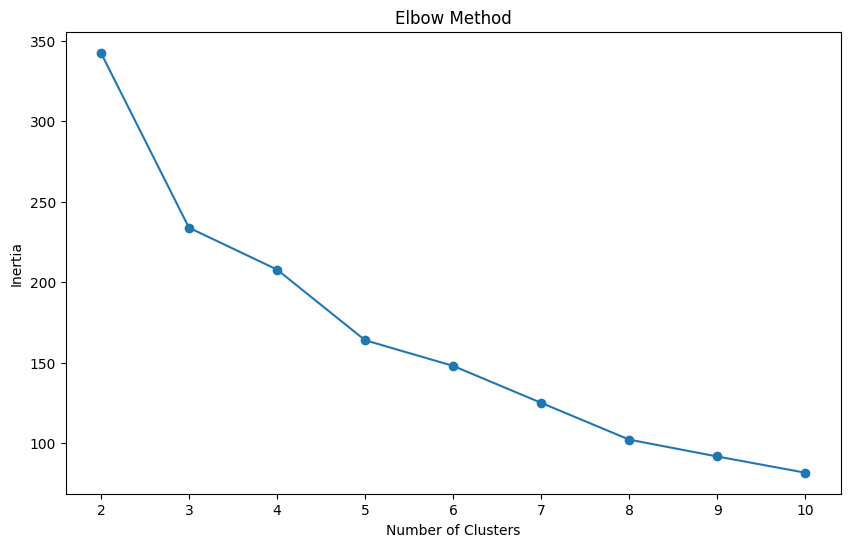

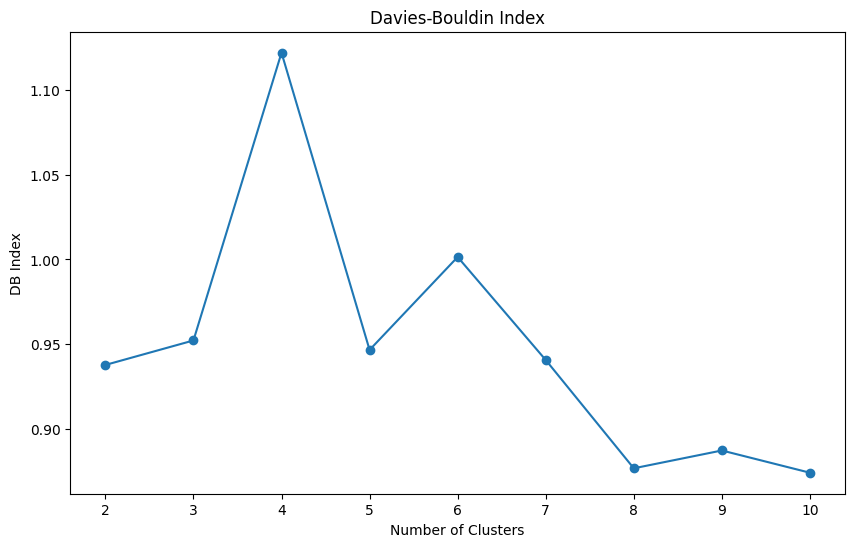

In [4]:
# Determine the optimal number of clusters using the Elbow method
inertia = []
db_index = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    db_index.append(davies_bouldin_score(X_scaled, kmeans.labels_))

# Plot the Elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot the DB Index
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_index, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Choose the optimal number of clusters (e.g., based on the Elbow method and DB Index)
optimal_clusters = 3

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Evaluation
Calculate clustering metrics, including the Davies-Bouldin (DB) Index.

In [5]:
# Calculate DB Index
db_index_value = davies_bouldin_score(X_scaled, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index_value}')

# Calculate additional clustering metrics
silhouette_avg = silhouette_score(X_scaled, customer_features['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Davies-Bouldin Index: 0.95227765676549
Silhouette Score: 0.3724362900726579


# Step 5: Visualization
Visualize the clusters using relevant plots.



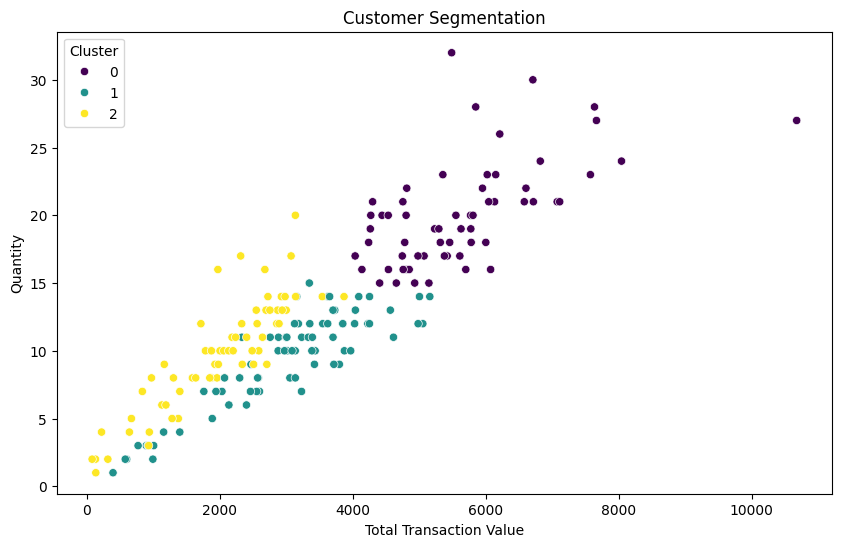

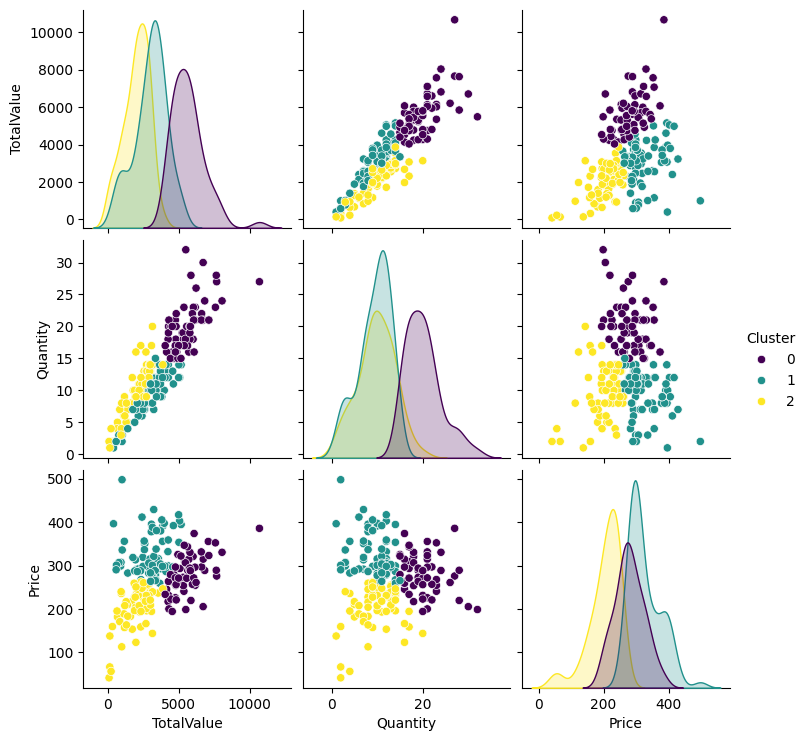

In [6]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='TotalValue', y='Quantity', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Total Transaction Value')
plt.ylabel('Quantity')
plt.show()

# Visualize the clusters in a pairplot
sns.pairplot(customer_features, hue='Cluster', palette='viridis', diag_kind='kde')
plt.show()